In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from lmfit import minimize, Parameters, report_fit
import pandas as pd
import datetime
import matplotlib.dates as mdates
from scipy.interpolate import interp1d

In [ ]:

# load URLs
#confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/refs/heads/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
#deaths_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/refs/heads/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'

# read csvs
#confirmed_cases = pd.read_csv(confirmed_cases_url)
#deaths = pd.read_csv(deaths_url)

In [ ]:
#Getting the data. The cell above can be used if you don't have the data downloaded already

confirmed_cases = pd.read_csv("time_series_covid19_confirmed_US.csv")
deaths = pd.read_csv("time_series_covid19_deaths_US.csv")

# choose cities of interest
cities = ['Churchill']
state = ['Nevada']
confirmed_dict = {}
deaths_dict = {}

# restrict to chosen cities
for city, st in zip(cities, state):
    new_df_confirmed = confirmed_cases[(confirmed_cases['Admin2'] == city) & (confirmed_cases['Province_State'] == st)]
    confirmed_dict[city] = new_df_confirmed

    new_df2_confirmed = deaths[(confirmed_cases['Admin2'] == city) & (confirmed_cases['Province_State'] == st)]
    deaths_dict[city] = new_df2_confirmed


def get_data_for_city(city_name):
    confirmed_df = confirmed_dict[city_name]
    date_cols = confirmed_df.columns[12:]
    confirmed_cases = confirmed_df.iloc[0]

    # Only select the date columns for plotting
    confirmed_dates = date_cols
    confirmed_cases = confirmed_cases[date_cols].astype(float)

    deaths_df = deaths_dict[city_name]
    date_cols = confirmed_df.columns[12:]
    deaths = deaths_df.iloc[0]

    deaths = deaths[date_cols].astype(float)

    return confirmed_cases, deaths

def plot_infected_fractions(city_name, start_date, end_date, population):

    confirmed_df = confirmed_dict[city_name]
    date_cols = confirmed_df.columns[12:]
    confirmed_cases = confirmed_df.iloc[0]

    # Only select the date columns for plotting
    confirmed_cases = confirmed_cases[date_cols].astype(float)

    # Find the indices for the desired date range
    start_date = start_date
    end_date = end_date
    date_range = confirmed_cases.index
    start_idx = date_range.get_loc(start_date)
    end_idx = date_range.get_loc(end_date) + 1  # +1 to include the end date

    # Compute the 14-day rolling mean of new cases per population for the selected range
    fraction_infected = confirmed_cases.diff().rolling(14, min_periods=1).mean() / population

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(date_range[start_idx:end_idx], fraction_infected.iloc[start_idx:end_idx], label=city_name, color="k", linewidth=3)
    plt.legend(loc='best')
    tick_locs = range(0, len(date_range[start_idx:end_idx]), 30)
    tick_labels = date_range[start_idx:end_idx][tick_locs]
    plt.xticks(ticks=tick_locs, labels=tick_labels, rotation=45)
    plt.xlabel('Date')
    plt.ylabel('Fraction of the infected')
    plt.title('Plot of Fraction of Population Infected', fontsize=15)
    plt.grid()
    plt.tight_layout()
    plt.show()

    return fraction_infected.iloc[start_idx:end_idx]

def plot_dead_fractions(city_name, start_date, end_date, population):

    death_df = deaths_dict[city_name]
    date_cols = death_df.columns[12:]
    death_cases = death_df.iloc[0]

    # Only select the date columns for plotting
    death_cases = death_cases[date_cols].astype(float)

    # Find the indices for the desired date range
    start_date = start_date
    end_date = end_date
    date_range = death_cases.index
    start_idx = date_range.get_loc(start_date)
    end_idx = date_range.get_loc(end_date) + 1  # +1 to include the end date

    # Compute the 14-day rolling mean of new cases per population for the selected range
    fraction_dead = death_cases / population

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(date_range[start_idx:end_idx], fraction_dead.iloc[start_idx:end_idx], label=city_name, color="k", linewidth=3)
    plt.legend(loc='best')
    tick_locs = range(0, len(date_range[start_idx:end_idx]), 30)
    tick_labels = date_range[start_idx:end_idx][tick_locs]
    plt.xticks(ticks=tick_locs, labels=tick_labels, rotation=45)
    plt.xlabel('Date')
    plt.ylabel('Fraction of deaths')
    plt.title('Plot of Fraction of Death', fontsize=15)
    plt.grid()
    plt.tight_layout()
    plt.show()

    return fraction_dead.iloc[start_idx:end_idx]



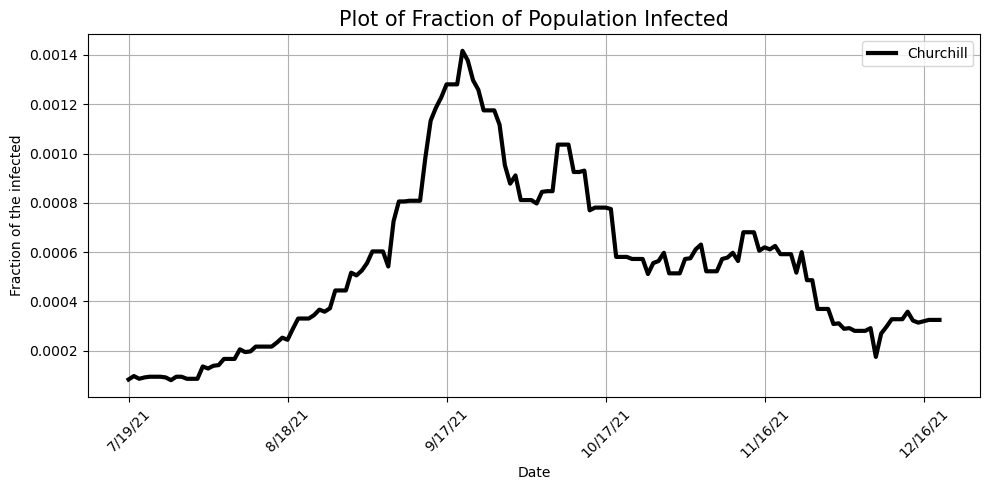

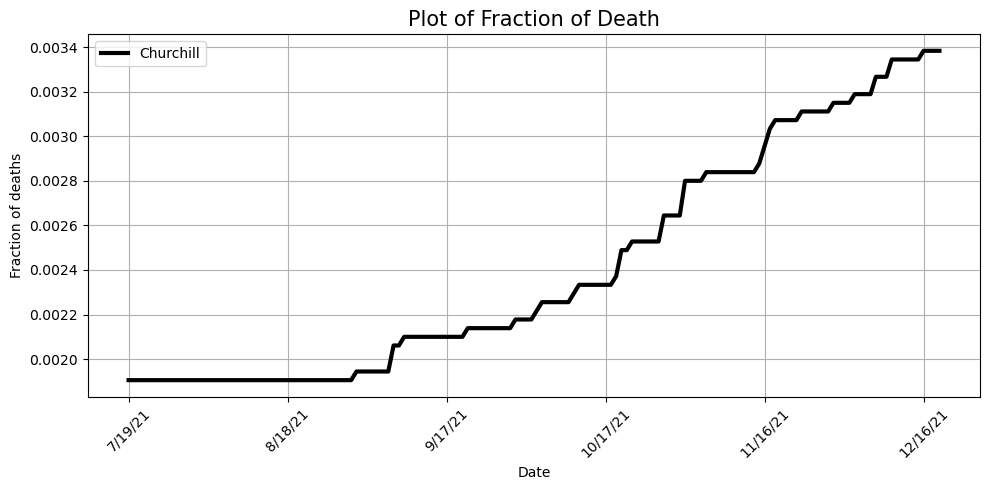

In [9]:

population = 25715

start_date = '7/19/21'
end_date = '12/19/21'

churchill_infected = plot_infected_fractions("Churchill", start_date, end_date, population)
churchill_death = plot_dead_fractions("Churchill", start_date, end_date, population)

In [10]:
t = np.linspace(0,len(churchill_infected)-1,len(churchill_infected))
data = churchill_infected.values
y0 = [1-churchill_infected[0],churchill_infected[0],0.0,0.0]

/var/folders/pm/jyq8qspx5_d52hvb6_pd9scr0000gn/T/ipykernel_80360/2452616171.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y0 = [1-churchill_infected[0],churchill_infected[0],0.0,0.0]


<h1>Stochastic simulations using fitted params</h1>

In [11]:
def sihrs_agent_model(N, params, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # Initial populations
    s0 = round(params['s0'] * N)
    i0 = round(params['i0'] * N)
    h0 = round(params['h0'] * N)
    r0 = round(params['r0'] * N)
    d0 = round(params['d0'] * N)

    total = s0 + i0 + h0 + r0 + d0
    if total != N:
        # Adjust the largest group to match total N
        counts = np.array([s0, i0, h0, r0, d0])
        idx = np.argmax(counts)
        counts[idx] += N - total
        s0, i0, h0, r0, d0 = counts

    # Track agents by index
    S = list(range(s0))
    I = list(range(s0, s0 + i0))
    H = list(range(s0 + i0, s0 + i0 + h0))
    R = list(range(s0 + i0 + h0, s0 + i0 + h0 + r0))
    D = list(range(s0 + i0 + h0 + r0, N))

    # Tracking results
    max_events = N*10
    T = np.zeros(max_events)
    S_prop = np.zeros(max_events)
    I_prop = np.zeros(max_events)
    H_prop = np.zeros(max_events)
    R_prop = np.zeros(max_events)
    D_prop = np.zeros(max_events)
    I_count = np.zeros(max_events, dtype=int)

    t = 0
    event_count = 0

    def update_props():
        total_pop = len(S) + len(I) + len(H) + len(R) + len(D)
        S_prop[event_count] = len(S) / total_pop
        I_prop[event_count] = len(I) / total_pop
        H_prop[event_count] = len(H) / total_pop
        R_prop[event_count] = len(R) / total_pop
        D_prop[event_count] = len(D) / total_pop
        I_count[event_count] = len(I)
        T[event_count] = t

    update_props()

    while len(I) > 0 and t < params['tmax']:
        nS, nI, nH, nR = len(S), len(I), len(H), len(R)

        # Calculate rates
        infection_rate = params['pSI'] * params['beta'] * nS * nI / N
        r_to_s_rate = params['pRS'] * params['lambda_'] * nR
        i_to_h_rate = params['gamma'] * nI * params['pIH']
        i_to_r_rate = params['gamma'] * nI * params['pIR']
        i_to_d_rate = params['gamma'] * nI * params['pID']
        h_to_r_rate = params['alpha'] * nH * params['pHR']
        h_to_d_rate = params['alpha'] * nH * params['pHD']

        total_rate = sum([
            infection_rate, r_to_s_rate, i_to_h_rate,
            i_to_r_rate, i_to_d_rate, h_to_r_rate, h_to_d_rate
        ])

        if total_rate == 0:
            break

        dt = np.random.exponential(1 / total_rate)
        t += dt
        event_count += 1
        if event_count >= max_events:
            break

        update_props()

        rand = np.random.uniform(0, total_rate)
        threshold = 0

        def pop_and_push(from_list, to_list):
            i = np.random.randint(len(from_list))
            agent = from_list.pop(i)
            to_list.append(agent)

        if rand < (threshold := threshold + infection_rate):
            if S:
                pop_and_push(S, I)
        elif rand < (threshold := threshold + r_to_s_rate):
            if R:
                pop_and_push(R, S)
        elif rand < (threshold := threshold + i_to_h_rate):
            if I:
                pop_and_push(I, H)
        elif rand < (threshold := threshold + i_to_r_rate):
            if I:
                pop_and_push(I, R)
        elif rand < (threshold := threshold + i_to_d_rate):
            if I:
                pop_and_push(I, D)
        elif rand < (threshold := threshold + h_to_r_rate):
            if H:
                pop_and_push(H, R)
        else:
            if H:
                pop_and_push(H, D)

    # Trim arrays to the actual number of events
    T = T[:event_count + 1]
    S_prop = S_prop[:event_count + 1]
    I_prop = I_prop[:event_count + 1]
    H_prop = H_prop[:event_count + 1]
    R_prop = R_prop[:event_count + 1]
    D_prop = D_prop[:event_count + 1]
    I_count = I_count[:event_count + 1]

    result = {
        'N': N,
        'T': T,
        'S_prop': S_prop,
        'I_prop': I_prop,
        'H_prop': H_prop,
        'R_prop': R_prop,
        'D_prop': D_prop,
        'I_count': I_count,
        'final_time': t,
        'peak_infected': np.max(I_count),
        'peak_time': T[np.argmax(I_count)],
        's_inf': S_prop[-1],
        'i_inf': I_prop[-1],
        'h_inf': H_prop[-1],
        'r_inf': R_prop[-1],
        'd_inf': D_prop[-1]
    }

    return result



In [25]:
i0 = churchill_infected.values[0]
d0 = churchill_death.values[0]
T=len(churchill_infected)
dt=1

params = {
    'beta': 0.5035,
    'gamma': 0.5,
    'alpha': 0.5,
    'lambda_': 0.083,
    'pSI': 1.0,
    'pII': 0.0,
    'pIH': 0.035,
    'pIR': 0.945,
    'pID': 0.020,
    'pHH': 0.0,
    'pHR': 0.92,
    'pHD': 0.08,
    'pRR': 0.02,
    'pRS': 0.98,
    'tmax': T,
    's0': 1-i0,
    'i0': i0,
    'h0': 0.0,
    'r0': 0.0,
    'd0': d0
}

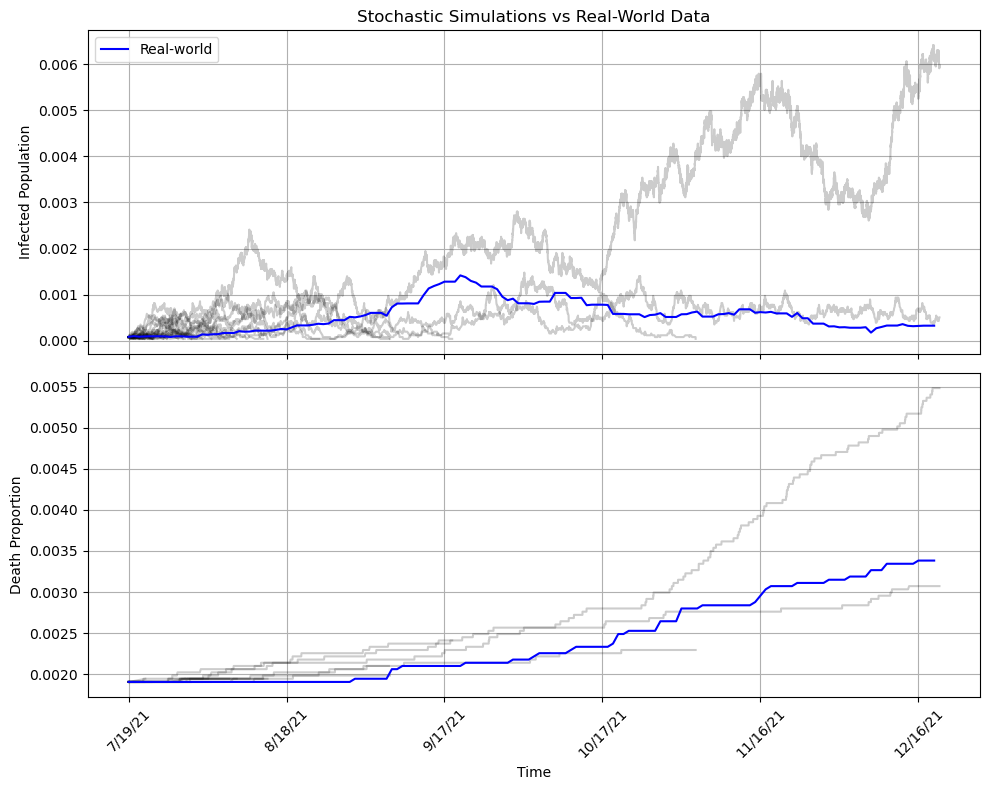

In [45]:
confirmed_df = confirmed_dict['Churchill']
date_cols = confirmed_df.columns[12:]
confirmed_cases = confirmed_df.iloc[0]

# Only select the date columns for plotting
confirmed_cases = confirmed_cases[date_cols].astype(float)

date_range = confirmed_cases.index
start_idx = date_range.get_loc(start_date)
end_idx = date_range.get_loc(end_date) + 1  # +1 to include the end date

ts_uniform = np.arange(0, T + dt,  dt)
I_all = np.empty((30,len(ts_uniform)))
D_all = np.empty((30,len(ts_uniform)))

fig, axs = plt.subplots(2,1,figsize=(10,8),sharex=True)

for i in range(30):
  result = sihrs_agent_model(N=25715,params=params)

  ts = result['T'] 
  I = result['I_prop']
  D = result['D_prop']
  interp_I = interp1d(ts, I, fill_value= (0, 0), bounds_error=False)
  interp_D = interp1d(ts, D, fill_value= (0, 0), bounds_error=False)

  I_all[i] = interp_I(ts_uniform)
  D_all[i] = interp_D(ts_uniform)

  axs[0].plot(ts, I, color='k', alpha = 0.2)
  axs[1].plot(ts,D, color='k', alpha=0.2)

axs[0].plot(t, churchill_infected.values, label='Real-world', color='b')
axs[0].set_ylabel('Infected Population')
axs[0].legend()
axs[0].grid(True)
axs[0].set_title('Stochastic Simulations vs Real-World Data')

axs[1].plot(t, churchill_death.values, label='Real-world', color='b')
axs[1].set_ylabel('Death Proportion')
axs[1].grid(True)
axs[1].set_xlabel('Time')
tick_locs = range(0, len(date_range[start_idx:end_idx]), 30)
tick_labels = date_range[start_idx:end_idx][tick_locs]
plt.xticks(ticks=tick_locs, labels=tick_labels, rotation=45)

plt.tight_layout()
plt.show()

<h2>Code for fitting ODE to real-world</h2>
We won't use this technique but I'm dropping it here.

In [ ]:
#Defining the system of ODEs
def sihr_ode(t, y, params):
    alpha = params['alpha']
    beta = params['beta']
    gamma = params['gamma']
    ph = params['ph']

    s, i, h, r = y[0],y[1],y[2],y[3]
    dydt = [
        -beta*s*i,
        beta*s*i - gamma*i,
        ph * gamma*i - alpha*h,
        alpha*h + (1-ph) * gamma*i
    ]
    return dydt

In [ ]:
# the residual function to minimize
def residual(params, t, data, y0):
    sol = solve_ivp(lambda t, y: sihr_ode(t, y, params),
                    [t[0], t[-1]], y0, t_eval=t, method='RK45')
    model = sol.y
    return (model[1] - data).ravel()  # Flatten for lmfit

In [ ]:
t = np.linspace(0,len(churchill_infected)-1,len(churchill_infected))
data = churchill_infected.values
y0 = [1-churchill_infected[0],churchill_infected[0],0.0,0.0]

In [ ]:
#Define initial guess for fitting
fit_params = Parameters()
fit_params.add('alpha', value=0.05, min=0)
fit_params.add('beta', value=1.0, min=0)
fit_params.add('ph', value=0.75, min=0, max=1)
fit_params.add('gamma', value=0.8, min=0)
result = minimize(residual, fit_params, args=(t, data, y0))
report_fit(result)

In [ ]:
sol_fit = solve_ivp(lambda t, y: sihr_ode(t, y, result.params),
                    [t[0], t[-1]], y0, t_eval=t)

plt.figure(figsize=(10,5))
plt.plot(t, churchill_infected.values)
plt.plot(t, sol_fit.y[1], 'r-', label='i fitted')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.tight_layout()
plt.show()

fitted params for churchill: 
    beta=1.13,
    gamma=1.08

In [ ]:
par = {'beta':1.129,
       'gamma':1.08,
       'alpha':0.5,
       'ph':0.5}
sol_fit = solve_ivp(lambda t, y: sihr_ode(t, y, par),
                    [t[0], t[-1]], y0, t_eval=t)

plt.figure(figsize=(10,5))
plt.plot(t, churchill_infected.values)
plt.plot(t, sol_fit.y[1], 'r-', label='i fitted')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.tight_layout()
plt.show()